In [47]:
from getdist import plots, MCSamples
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import getdist
import h5py

import numpy as np
import os
import sacc
import scipy.stats
import sys
import yaml
from scipy.interpolate import interp1d
import pyccl as ccl
import latextable
from texttable import Texttable

from cobaya.samplers.mcmc import plot_progress
from getdist.mcsamples import MCSamplesFromCobaya

from scipy import stats
from scipy.interpolate import interp1d

from cobaya.model import get_model
from cobaya.input import load_input
from cl_like import ClLike

import healpy as hp
import sacc
import fitsio

#### Import baccoemu to check within ranges
import baccoemu
import warnings

nonlinear_emu_path='/mnt/zfsusers/gravityls_3/codes/NN_emulator_PCA6_0.95_300_400n_paired_comb'
nonlinear_emu_details='details.pickle'

mpk = baccoemu.Matter_powerspectrum(nonlinear_emu_path=nonlinear_emu_path,
                                    nonlinear_emu_details=nonlinear_emu_details)

#### Chain handling ####
class Chain(dict):
    def __init__(self, MCSamples, label, color, path, Cobaya=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self['MCSamples'] = MCSamples
        self['label'] = label
        self['color'] = color
        self['path'] = path
        # We subtract 4 for minuslogprior, minuslogprior__0, chi2, chi2__cl_like.ClLike
        # We load this at the beginning for correct R-1
        self['npar'] = len(MCSamples.getParamNames().list()) - 4      
        # self['R-1'] = MCSamples.getGelmanRubin(npar)
        self.model = None
        self.lkl = None
        self.Rminus1 = None
        self.chi2bf = None
        self.parsbf = None
        self.pvaluebf = None
        self.clsacc_bf = None
        self.cldata = None
        self._derived_added = False
        self.pk_data_bf = None
        self.ndata = None
        self._MAP_info = None
        
    def _get_model(self):
        if self.model is None:
            path = self['path'] + '.input.yaml'
            if not os.path.isfile(path):
                raise ValueError('These chains are not from cobaya, so you cannot load the model')
            self.model = get_model(path)
        return self.model
    
    def _get_Rminus1(self):
        if self.Rminus1 is None:
            self.Rminus1 = self['MCSamples'].getGelmanRubin(self.get('npar'))
        return self.Rminus1
    
    def _get_chi2bf(self):
        if self.chi2bf is None:
            pars = self['MCSamples'].getParams()
            self.chi2bf = pars.chi2__cl_like.ClLike.min()
        return self.chi2bf
    
    def _get_parsbf(self):
        if self.parsbf is None:
            chain = self['MCSamples']
            pars = chain.getParams()
            self.parsbf = chain.getParamSampleDict(pars.chi2__cl_like.ClLike.argmin())
        return self.parsbf
    
    def _get_ndata(self):
        if self.ndata is None:
            model = self._get_model()
            self.ndata = model.likelihood['cl_like.ClLike'].ndata
        return self.ndata
    
    def get_pvalue(self, pars):
        chi2 = self.evaluate_model(pars)
        ndata = self._get_ndata()
        return 1 - stats.chi2.cdf(chi2, df=ndata - 2)
    
    def _get_pvaluebf(self):
        if self.pvaluebf is None:
            # pars = self._get_parsbf()
            # self.pvaluebf = self.get_pvalue(pars)
            chi2bf = self._get_chi2bf()
            ndata = self._get_ndata()
            self.pvaluebf = 1 - stats.chi2.cdf(chi2bf, df=ndata - 2)
        return self.pvaluebf

    # MAP
    def _get_MAP_info(self):
        if self._MAP_info is None:
            sample = self['MCSamples']
            ix = np.argmin(sample.loglikes)
            chi2_map = sample.loglikes[ix]
            pars_map = sample.getParamSampleDict(ix)
            chi2_wl_map = self.evaluate_model(pars_map)[0]
            ndata = self._get_ndata()
            pvalue_map = 1 - stats.chi2.cdf(chi2_wl_map, df=ndata - 2)

            self._MAP_info = {'chi2_map': chi2_map, 'pars_map': pars_map, 'chi2_wl_map': chi2_wl_map, 'pvalue_wl_map': pvalue_map}
            
        return self._MAP_info
    
    def add_derived(self, extrapolate_h=False):
        if self._derived_added is True:
            return
        MCSamples = self['MCSamples']
        p = MCSamples.getParams()
        pn = MCSamples.getParamNames().list()
        
        # S8 = p.sigma8 * np.sqrt(p.Omega_m / 0.3)
        if ('S8' not in pn) and ('S_8' in pn):
            S8 = p.S_8
            MCSamples.addDerived(S8, 'S8', label='S_8')
           
        if ('h' not in pn) and ('H0' in pn):
            MCSamples.addDerived(p.H0/100, 'h', label='h')
        if ('Omega_c' not in pn) and ('Omega_cdm' in pn):
            MCSamples.addDerived(p.Omega_cdm, 'Omega_c', label=r'\Omega_c')

        p = MCSamples.getParams()
        pn = MCSamples.getParamNames().list()
        if 'Omega_m' not in pn:
            Omega_m = p.Omega_b + p.Omega_c
            if 'm_nu' in pn:
                Omega_m +=  p.Omega_nu
            MCSamples.addDerived(Omega_m, 'Omega_m', label=r'\Omega_m')
        if 'sigma8' not in pn:
            if 'sigma_8' in pn:
                MCSamples.addDerived(p.sigma_8, 'sigma8', label=r'\sigma_8')
            elif 'S8' in pn:
                MCSamples.addDerived(p.S8 * np.sqrt(0.3 / p.Omega_m), 'sigma8', label=r'\sigma_8')
        if 'm_nu' in pn:
            m_nu = p.m_nu
            MCSamples.addDerived(p.m_nu/(93.14*p.h**2), 'Omega_nu', label=r'\Omega_\nu')
        else:
            m_nu = np.zeros_like(p.h)
            
        p = MCSamples.getParams()
        pn = MCSamples.getParamNames().list()            
        if ('S8' not in pn) and ('sigma8' in pn and 'Omega_m' in pn):
             MCSamples.addDerived(p.sigma8 * np.sqrt(p.Omega_m / 0.3), 'S8', label='S_8')
            
        # Baryon fraction
        MCSamples.addDerived(p.Omega_b / (p.Omega_c + p.Omega_b), 'baryon_fraction', label=r'\frac{\Omega_b}{\Omega_{\rm cold}}')
        
        p = MCSamples.getParams()
        pn = MCSamples.getParamNames().list()
        h = p.h 
        if 'omega_b' not in pn:
            MCSamples.addDerived(p.Omega_b * h**2, 'omega_b', label='\omega_b')
        if 'omega_c' not in pn:
            MCSamples.addDerived(p.Omega_c * h**2, 'omega_cdm', label='\omega_{cdm}')
        if 'omega_m' not in pn:
            MCSamples.addDerived(p.Omega_m * h**2, 'omega_m', label='\omega_{m}')
        
        p = MCSamples.getParams()
        pn = MCSamples.getParamNames().list()


        # Add S12 and sigma8_cold. Note that here we might change h to extrapolate.
        if extrapolate_h:
            sel = h>0.9 # Which is the upper bound of h in baccoemu
            if np.sum(sel) > 0:
                warnings.warn(f"#### Extrapolating h for {np.sum(sel)/p.h.size * 100:.2f}%. Max h = {p.h.max()}")
                h[sel] = 0.9
        # Sigma12
        if 'S12' not in pn and (('A_s' in pn) or ('A_sE9' in pn)):
            pars = {
            'omega_cold':p.Omega_c + p.Omega_b,
            'omega_baryon': p.Omega_b,
            'A_s' : p.A_sE9*1e-9 if 'A_sE9' in pn else p.A_s,
            'ns': p.n_s,
            'hubble': h,
            'neutrino_mass': m_nu,
            'w0': np.full(h.size, -1),
            'wa': np.full(h.size, 0),
            'expfactor': np.full(h.size, 1)
            }

            try:
                sigma12 = mpk.get_sigma12(cold=False, **pars)
                S12 = sigma12 * (p.omega_m / 0.14)**0.4
                MCSamples.addDerived(sigma12, 'sigma12', label='\sigma_{12}')
                MCSamples.addDerived(S12, 'S12', label='S_{12}')
            except AssertionError as e:
                if 'out of bounds' in str(e):
                    warnings.warn(str(e) + " Not adding S12 for this chain.")
                    
        if 'sigma8_cold' not in pn and (('A_s' in pn) or ('A_sE9' in pn)):
            pars = {
            'omega_cold':p.Omega_c + p.Omega_b,
            'omega_baryon': p.Omega_b,
            'A_s' : p.A_sE9*1e-9 if 'A_sE9' in pn else p.A_s,
            'ns': p.n_s,
            'hubble': h,
            'neutrino_mass': m_nu,
            'w0': np.full(h.size, -1),
            'wa': np.full(h.size, 0),
            'expfactor': np.full(h.size, 1)
            }
            try:
                sigma8_cold = mpk.get_sigma8(cold=True, **pars)
                MCSamples.addDerived(sigma8_cold, 'sigma8_cold', label='\sigma_{8,cold}')
            except AssertionError as e:
                if 'out of bounds' in str(e):
                    warnings.warn(str(e) + " Not adding sigma8_cold for this chain.")
            
        return
    
    def __getitem__(self, key):
        if key not in self.keys():
            if key == 'model':
                self[key] = self._get_model()
            elif key == 'lkl':
                self[key] = self.get_lkl()
            elif key == 'R-1':
                self[key] = self._get_Rminus1()
            elif key == 'chi2bf':
                self[key] = self._get_chi2bf()
            elif key == 'pars_bf':
                self[key] = self._get_parsbf()
            elif key == 'ndata':
                self[key] = self._get_ndata()
            elif key == 'pvalue_bf':
                self[key] = self._get_pvaluebf()
            elif key == 'data_sacc':
                self[key] = self.get_cl_data_sacc()
            elif key == 'bf_sacc':
                self[key] = self.get_cl_theory_sacc_bf()
            elif key == 'pk_data_bf':
                self[key] = self.get_pk_data_bf()
            elif key == 'Sk_bf':
                self[key] = self.get_Sk_bf()
            elif key == 'chi2_map':
                self[key] = self._get_MAP_info()['chi2_map']
            elif key == 'pars_map':
                self[key] = self._get_MAP_info()['pars_map']
            elif key == 'chi2_wl_map':
                self[key] = self._get_MAP_info()['chi2_wl_map']                
            elif key == 'pvalue_map':
                self[key] = self._get_MAP_info()['pvalue_wl_map']
            else:
                raise ValueError('You need to implement this!')
        return self.get(key)

    def evaluate_model(self, params):
        model = self._get_model()
        pars = {p: params[p] for p in model.parameterization.sampled_params().keys()}
        return -2 * model.loglikes(pars)[0]

    def get_lkl(self):
        if self.lkl is None:
            model = self._get_model()
            self.lkl = model.likelihood['cl_like.ClLike']
        return self.lkl
    
    def get_cl_theory(self, pars):
        self.evaluate_model(model, pars)
        return model.provider.get_cl_theory()

    def get_cl_theory_sacc(self, pars):
        self.evaluate_model(pars)
        lkl = self.get_lkl()
        return lkl.get_cl_theory_sacc()
    
    def get_cl_theory_sacc_bf(self):
        if self.clsacc_bf is None:
            pars = self._get_parsbf()
            self.clsacc_bf = self.get_cl_theory_sacc(pars)
        return self.clsacc_bf
    
    def get_cl_data_sacc(self):
        if self.cldata is None:
            lkl = self.get_lkl()
            self.cldata = lkl.get_cl_data_sacc()
        return self.cldata
    
    def get_pk_data(self, pars):
        self.evaluate_model(pars)
        lkl = self.get_lkl()
        return lkl.provider.get_Pk()['pk_data']
    
    def get_pk_data_bf(self):
        if self.pk_data_bf is None:
            pars = self._get_parsbf()
            self.pk_data_bf = self.get_pk_data(pars)
        return self.pk_data_bf

    def plot_chain(self, param):
        s = self['MCSamples']
        chains = s.getSeparateChains()
        pnames = s.getParamNames().list()
        
        ixpname = pnames.index(param)
        
        f, ax = plt.subplots(len(chains), 1, figsize=(8, 3*len(chains)))
        for i, c in enumerate(chains):
            ax[i].plot(c.samples[:, ixpname])
            ax[i].set_ylabel(pnames[ixpname])
        plt.show()
        plt.close()

class BaryonBoost():
    def __init__(self, fname, ignore_rows=0):
        self.boost = []
        self.weights = []
        self.loglikes = []
        if '.npz' in fname:
            kdjdkjdk
            
            npf = np.load(f"{fname}")
            self.boost.append(npf['Sk'])
            self.weights.append(npf['weights'])
            if 'loglikes' in npf.keys():
                self.loglikes.append(npf['loglikes'])
        else:
            for i in range(4):
                npf = np.load(f"{fname}.{i+1}_Sk_in_hoverMpc.npz")
                self.boost.append(npf['Sk'][:, 1:])
                self.weights.append(npf['weights'])
                if 'loglikes' in npf.keys():
                    self.loglikes.append(npf['loglikes'])
        
        if self.loglikes == []:
            self.loglikes = None
        
        self.k_arr = npf['k_arr'][1:]
        self.k_arr[0] = 0.01
        self.InlineLatexList = None
        self.post1D = None
        self.post_interp = None
        
        # For the MCSamples
        self.MCSamples_baryons = None
        self._names =  npf['colnames'][1:]
        self._labels = [f'S(k={ki:.2f})' for ki in self.k_arr]
        self.ignore_rows = ignore_rows

        

        # Decide whether you risk with limits or only uses InlineLatex with \pm
        self.only_pm = True
        self.getdist_1D = False

    def set_getdist_1D(self, getdist_1D):
        if getdist_1D is not self.getdist_1D:
            self.getdist_1D = getdist_1D
            self.post1D = None
            self.post_interp = None        

    def set_only_pm(self, only_pm):
        if only_pm is not self.only_pm:
            self.only_pm = only_pm
            self.post1D = None
            self.post_interp = None
        
    def get_k_arr(self):
        return self.k_arr
    
    def get_names(self):
        return self._names
    
    def get_labels(self):
        return self._labels
    
    def get_MCSamples_baryons(self):
        if self.MCSamples_baryons is None:
            self.MCSamples_baryons = getdist.MCSamples(samples=self.boost,
                                                       weights=self.weights,
                                                       loglikes=self.loglikes,
                                                       names=self._names,
                                                       labels=self._labels,
                                                       ignore_rows=self.ignore_rows)
        return self.MCSamples_baryons
    
    def _transaleInlineLatex(self, InlineLatex):
        if ' = ' in InlineLatex:
            rhs = InlineLatex.split(' = ')[-1]
            if '\pm' in rhs:
                mean, errors = rhs.split('\pm')
                up = down = float(errors)
            else:
                mean, errors = rhs.split('^{')
                if '{+' in errors: 
                    # Weird case but it's there
                    up, down = errors.split('}_{+')
                    up = float(up)
                    down = float(down[:-1])
                    up = max(up, down)
                    down = 0
                else:
                    up, down = errors.split('}_{-')
                    up = float(up)
                    down = float(down[:-1]) # Remove the '}' at the end
            mean = float(mean)
        else:
            if self.only_pm:
                raise ValueError(f"Not well constrained {InlineLatex}")
            else:
                if '<' in InlineLatex:
                    lhs, rhs = InlineLatex.split('<')
                    mean = float(rhs) / 2.
                    up = down = mean
                elif '>' in InlineLatex:
                    warning.warns(f"Getting upper bound in {Inlinelatex}. Check if it makes sense to have Sk = 1 as maximum!!")
                    lhs, rhs = InlineLatex.split('>')
                    mean = (float(rhs) + 1.) / 2
                    down = mean - float(rhs) 
                    up = 1 - mean
        
        # Return the upper and lower bounds instead of the errors
        return mean, up, down
    
    def get_baryon_post1D(self):
        if self.post1D is None:
            samples = self.get_MCSamples_baryons()
            post1D = []
            if self.getdist_1D:
                InlineLatexList = []
                for namei in self.get_names():
                    InlineLatex = samples.getInlineLatex(namei)
                    post1D.append(self._transaleInlineLatex(InlineLatex))
                    InlineLatexList.append(InlineLatex)
                self.InlineLatexList = InlineLatexList
            else:
                w = samples.weights
                Sk_mean = np.average(samples.samples, weights=w, axis=0)
                Sk2_mean = np.average(samples.samples**2, weights=w, axis=0)
                Sk_std = np.sqrt(Sk2_mean - Sk_mean**2)
                post1D = np.transpose((Sk_mean, Sk_std, Sk_std))
            self.post1D = np.array(post1D)
        return self.post1D
    
    def get_baryon_post_interp(self, kind='quadratic'):
        if self.post_interp is None:
            mean, up, down = self.get_baryon_post1D().T
            post_interp = interp1d(self.k_arr, mean, kind=kind)
            post_interp_p1sigma = interp1d(self.k_arr, mean + up, kind=kind)
            post_interp_m1sigma = interp1d(self.k_arr, mean - down, kind=kind)
        
            self.post_interp = (post_interp, post_interp_p1sigma, post_interp_m1sigma)
        return self.post_interp
    
    def get_baryon_post_at_k(self, k):
        mean, up, down = self.get_baryon_post_interp(kind)
        return mean(k), up(k), down(k)
    
    def plot_baryon_post(self, ax, label, color, kind='quadratic', k_fine=None, alpha=0.5):
        if k_fine is None:
            k_fine = np.logspace(-1, np.log10(self.k_arr.max()), 100)
            k_fine[0] = 0.1
        mean, up, down = self.get_baryon_post_interp(kind)
        ax.semilogx(k_fine, mean(k_fine), color=color)
        ax.fill_between(k_fine, up(k_fine), down(k_fine),
                        alpha=alpha, color=color, label=label)
        
    def plot_baryon_post_errorbar(self, ax, label=None, color=None, fmt='.'):
        post1d = self.get_baryon_post1D()
        ax.errorbar(self.k_arr, post1d[:, 0], yerr=post1d[:, 1:].T[::-1],
                    fmt=fmt, label=label, color=color)

    
def load_chain(fname, label, color, ignore_rows=None, add_derived_params=True, baccoemu=True, extrapolate_h=False, **kwargs):
    # d = Chain(**{'MCSamples': getdist.loadMCSamples(fname, settings={'ignore_rows': ignore_rows}),
    d = {   
         'label': label,
         'color': color,
         'path': fname}
    
    # if add_derived_params:
    #     d.add_derived(extrapolate_h)
    
    # if baccoemu and ('fixedcosmo' not in fname):
    #     d['inbounds_baccoemu'] = count_inbounds_baccoemu_range(d['MCSamples'])
    
    if os.path.isfile(f"{fname}.1_Sk_in_hoverMpc.npz"):
        d['boost'] = BaryonBoost(fname, ignore_rows=ignore_rows)
        
    return d

##### Functions ######
def evaluate_model(model, params):
    pars = {p: params[p] for p in model.parameterization.sampled_params().keys()}
    return -2 * model.loglikes(pars)[0]

def get_cl_theory(model, pars):
    evaluate_model(model, pars)
    return model.provider.get_cl_theory()

def get_cl_theory_sacc(model, pars):
    evaluate_model(model, pars)
    lkl = model.likelihood['cl_like.ClLike']
    return lkl.get_cl_theory_sacc()

def get_cl_data_sacc(model):
    lkl = model.likelihood['cl_like.ClLike']
    return lkl.get_cl_data_sacc()

def transaleInlineLatex(InlineLatex):
    if ' = ' in InlineLatex:
        rhs = InlineLatex.split(' = ')[-1]
        if '\pm' in rhs:
            mean, errors = rhs.split('\pm')
            up = down = float(errors)
        else:
            mean, errors = rhs.split('^{')
            up, down = errors.split('}_{-')
            up = float(up)
            down = float(down[:-1])
        mean = float(mean)
    else:
        raise ValueError('This is not well constrained')

    # Return the upper and lower errors
    return mean, up, down



##### Global variables

results = {}

Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...


/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Tr

Linear emulator loaded in memory.
Loading no-wiggles emulator...


/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVer

No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons-sigma12/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [48]:
# Baryons (4096) lmax=8192
key = 'desy3wl_k1000_hsc_baryons_nocuts_nla_nside4096_lmax4500_lmin20_lmin100_lmin300_GNG'
results[key] = load_chain(f'./chains/{key}/{key}',
                           r'DESY3 + KiDS1000 + HSC with Baryons ($\ell < 4500$)', 'black', 0.15)
# print(key, f"R-1 = {results[key]['R-1']}")


In [56]:
chains = ['desy3wl_k1000_hsc_baryons_nocuts_nla_nside4096_lmax4500_lmin20_lmin100_lmin300_GNG']

colors = ['blue', 'orange', 'black']
labels = ['DESY3 + KiDS-1000 + HSC-DR1 ($\ell < 4500$)']

f, ax = plt.subplots()
for c in chains:
    print(f"Reading {c}")
    # label = results[c]['label']
    color = dict(zip(chains, colors))[c]
    label = dict(zip(chains, labels))[c]
    results[c]['boost'].plot_baryon_post(ax, label, color)

ax.axhline(1, ls='--', color='gray')
ax.set_xlabel(r'$k {\rm [h/Mpc]}$')
ax.set_ylabel('$S_k(a=1)$')
ax.legend(loc='lower left') # center', bbox_to_anchor=(0.5, 1.31),)
ax.set_xlim([None, 3])
plt.show()
plt.close()

Reading desy3wl_k1000_hsc_baryons_nocuts_nla_nside4096_lmax4500_lmin20_lmin100_lmin300_GNG


In [24]:
# k_fine = np.logspace(-1, np.log10(b.k_arr.max()), 100)
# k_fine[0] = 0.1
# mean, up, down = b.get_baryon_post_interp()
# m = mean(k_fine)
# err_up = up(k_fine)
# err_down = down(k_fine)

# fname = './chains/desy3wl_k1000_hsc_baryons_nocuts_nla_nside4096_lmax4500_lmin20_lmin100_lmin300_GNG/desy3wl_k1000_hsc_baryons_nocuts_nla_nside4096_lmax4500_lmin20_lmin100_lmin300_GNG_Sk_in_hoverMpc_posterior.npz'
# np.savez_compressed(fname, k_hoverMpc=k_fine, mean=m, upper_limit_1sigma=err_up, lower_limit_1sigma=err_down)


# plt.semilogx(k_fine, m, color=color)
# plt.fill_between(k_fine, err_up, err_down)

# f = np.load(fname)
# plt.semilogx(f['k_1overMpc'], f['mean'], color='red')
# plt.fill_between(f['k_1overMpc'], f['upper_limit_1sigma'], f['lower_limit_1sigma'], color='red', alpha=0.2)

# plt.show()
# plt.close()

In [50]:
b = results[c]['boost']
k_fine = np.logspace(-2, np.log10(4.5), 100)
mean, up, down = b.get_baryon_post_interp()
m = mean(k_fine)
err_up = up(k_fine)
err_down = down(k_fine)

fname = './chains/desy3wl_k1000_hsc_baryons_nocuts_nla_nside4096_lmax4500_lmin20_lmin100_lmin300_GNG/desy3wl_k1000_hsc_baryons_nocuts_nla_nside4096_lmax4500_lmin20_lmin100_lmin300_GNG_Sk_in_hoverMpc_posterior.npz'
np.savez_compressed(fname, k_hoverMpc=k_fine, mean=m, upper_limit_1sigma=err_up, lower_limit_1sigma=err_down)


plt.semilogx(k_fine, m, color=color)
plt.fill_between(k_fine, err_up, err_down)

f = np.load(fname)
plt.semilogx(f['k_hoverMpc'], f['mean'], color='red')
plt.fill_between(f['k_hoverMpc'], f['upper_limit_1sigma'], f['lower_limit_1sigma'], color='red', alpha=0.2)

plt.show()
plt.close()

In [44]:
b = results[c]['boost']

In [45]:
b.get_baryon_post1D(), b.k_arr.size

(array([[9.99832833e-01, 2.46040337e-04, 2.46040337e-04],
        [9.99833940e-01, 3.47929444e-04, 3.47929444e-04],
        [9.99340157e-01, 1.05371361e-03, 1.05371361e-03],
        [9.98663961e-01, 2.30309073e-03, 2.30309073e-03],
        [9.98010374e-01, 3.74033429e-03, 3.74033429e-03],
        [9.96582051e-01, 5.97468661e-03, 5.97468661e-03],
        [9.94224616e-01, 9.17019750e-03, 9.17019750e-03],
        [9.91190477e-01, 1.26318481e-02, 1.26318481e-02],
        [9.87902304e-01, 1.63433904e-02, 1.63433904e-02],
        [9.83848638e-01, 2.00275148e-02, 2.00275148e-02],
        [9.79437623e-01, 2.36521020e-02, 2.36521020e-02],
        [9.74732587e-01, 2.73123750e-02, 2.73123750e-02],
        [9.69826722e-01, 3.15131688e-02, 3.15131688e-02],
        [9.65323526e-01, 3.68536922e-02, 3.68536922e-02],
        [9.61992242e-01, 4.42747878e-02, 4.42747878e-02],
        [9.61528062e-01, 5.47440258e-02, 5.47440258e-02],
        [9.67334795e-01, 6.91022865e-02, 6.91022865e-02],
        [9.841

In [25]:
b = results['desy3wl_k1000_hsc_baryons_nocuts_nla_nside4096_lmax4500_lmin20_lmin100_lmin300_GNG']['boost']

In [29]:
b.boost[0].shape

(221922, 20)

In [51]:
f = np.load("chains/desy3wl_k1000_hsc_baryons_nocuts_nla_nside4096_lmax4500_lmin20_lmin100_lmin300_GNG/desy3wl_k1000_hsc_baryons_nocuts_nla_nside4096_lmax4500_lmin20_lmin100_lmin300_GNG.4_Sk_in_hoverMpc.npz")

In [55]:
np.abs(f['Sk'][:, 0] / f['Sk'][:, 1] - 1).max()

0.004928013727645175

In [58]:
for namei in b.get_names():
    print(b.MCSamples_baryons.getInlineLatex(namei))

S(k=0.01) = 0.99983^{+0.00023}_{-0.00018}
S(k=0.02) = 0.99983^{+0.00028}_{-0.000059}
S(k=0.03) = 0.99934^{+0.00077}_{+0.00015}
S(k=0.04) = 0.9987^{+0.0017}_{+0.00017}
S(k=0.05) = 0.9980^{+0.0026}_{+0.00085}
S(k=0.07) = 0.9966^{+0.0040}_{+0.0011}
S(k=0.10) = 0.9942^{+0.0063}_{+0.00093}
S(k=0.13) = 0.9912^{+0.0094}_{+0.000031}
S(k=0.18) = 0.988^{+0.014}_{-0.0019}
S(k=0.25) = 0.984^{+0.019}_{-0.0051}
S(k=0.35) = 0.979^{+0.025}_{-0.0091}
S(k=0.49) = 0.975^{+0.031}_{-0.013}
S(k=0.67) = 0.970^{+0.036}_{-0.014}
S(k=0.93) = 0.965^{+0.045}_{-0.017}
S(k=1.28) = 0.962^{+0.058}_{-0.031}
S(k=1.77) = 0.962^{+0.074}_{-0.042}
S(k=2.45) = 0.967^{+0.087}_{-0.056}
S(k=3.38) = 0.984^{+0.098}_{-0.085}
S(k=4.68) = 1.01^{+0.10}_{-0.12}


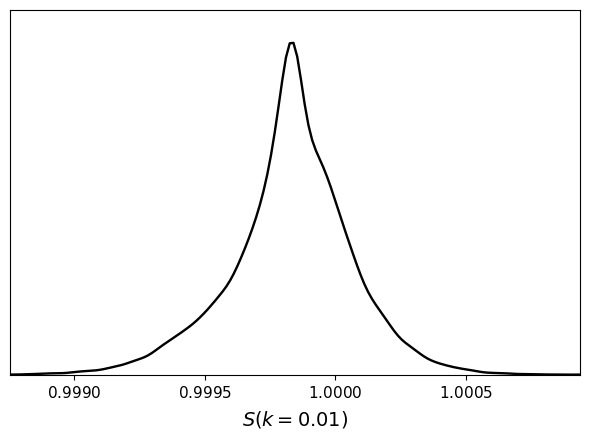

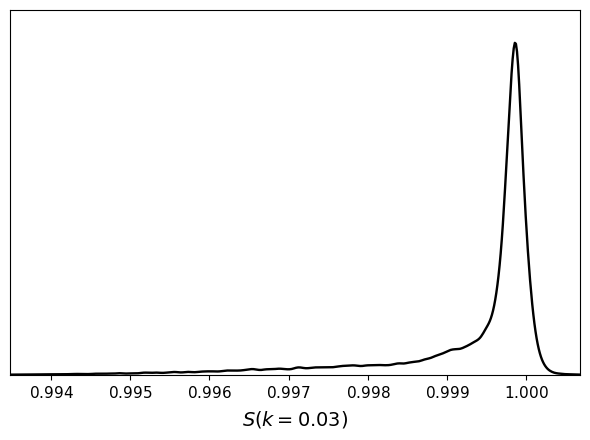

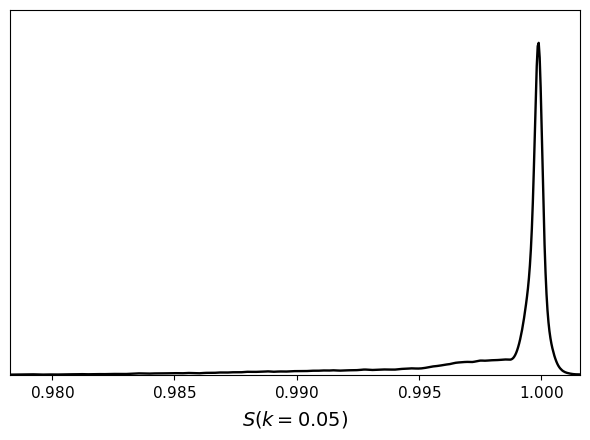

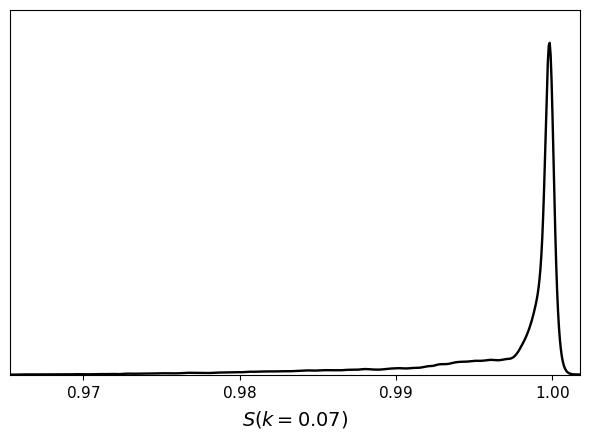

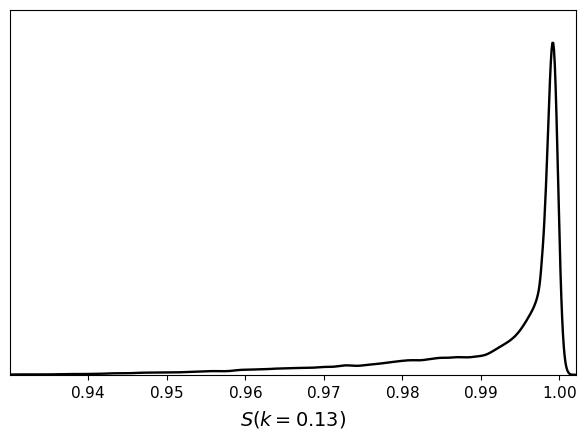

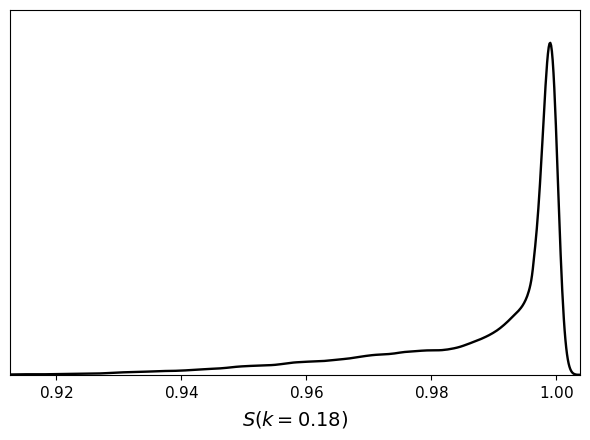

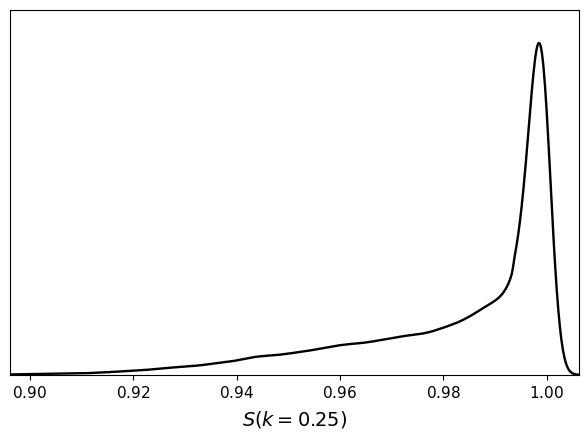

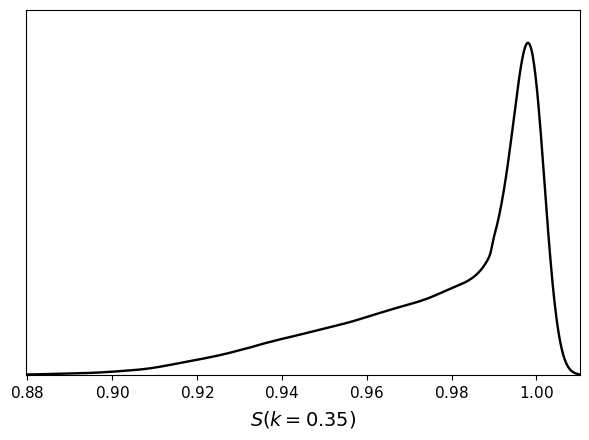

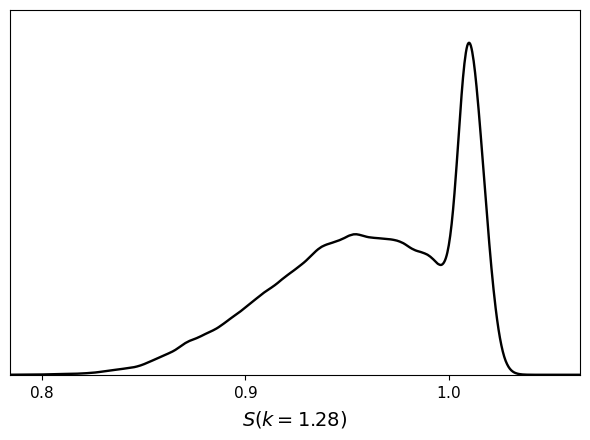

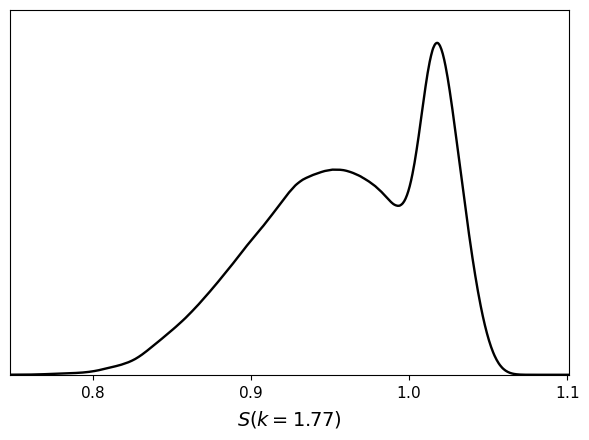

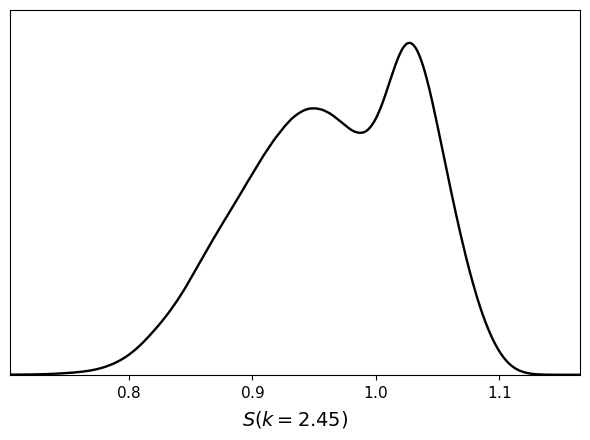

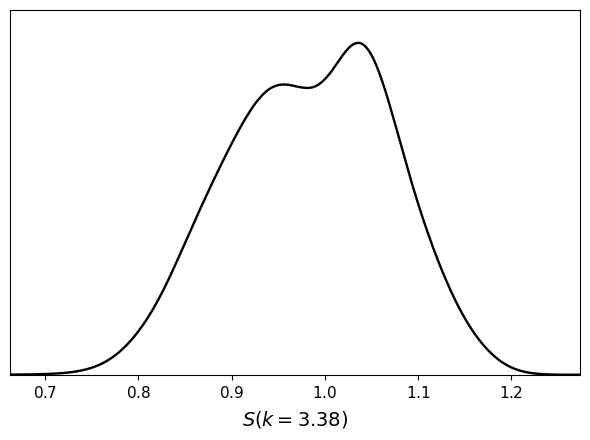

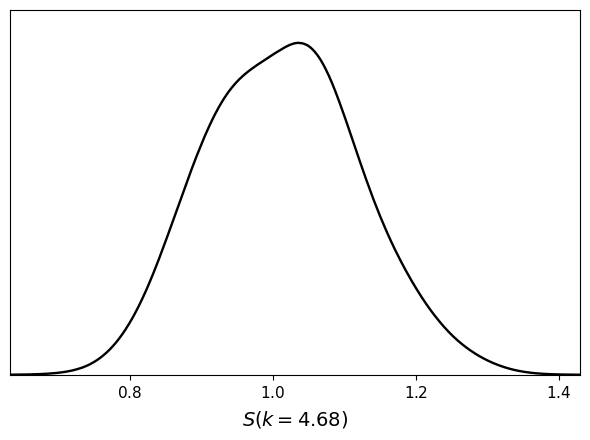

In [60]:
for namei in b.get_names():
    g = plots.get_single_plotter()
    g.plot_1d(b.MCSamples_baryons, namei)